<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Introduction

This notebook is an exploration of deep learning with Tensorflow based on the [Udacity 
Deep Learning Course by Google](https://www.udacity.com/course/deep-learning--ud730)
and [Martin Gorner's Tutorial](https://cloud.google.com/blog/big-data/2017/01/learn-tensorflow-and-deep-learning-without-a-phd)


The [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset is used in this notebook for exploration of deep learning. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

The procedure of creating the pickle file with formatted datasets is shown in details in `1_notmnist.ipynb`.  Here we just skip that part and use the generated dataset directly. The functions in this noteboook can be simplied applied on analysis of other databases.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [8]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

## Start Model

### Logistic Classification

In [39]:
def run_training(num_steps,graph,lr=1e-3,dropout=1.0,beta=0.0, relu = 1):
  with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print("Initialized")
      steps = []
      train_history = []
      valid_history = []
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,
                     learning_rate : lr, pkeep : dropout, regu_beta : beta, 
                     relu_flag : relu}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        print_step = num_steps//10
        if (step % print_step == 0):
          train_accuracy = accuracy(predictions, batch_labels)
          valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
          steps.append(step*lr)
          train_history.append(train_accuracy)
          valid_history.append(valid_accuracy)
          print("Minibatch loss at step %d: %f" % (step, l))
#           print("Minibatch accuracy: %.1f%%" % train_accuracy)
#           print("Validation accuracy: %.1f%%" % valid_accuracy)
      print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  return [steps, train_history,valid_history]

In [33]:
def plot_accuracy_history(result,title):
    plt.plot(result[0],result[1])
    plt.plot(result[0],result[2])
    plt.legend(['train_accuracy', 'validate_accuracy'], loc='lower right')
    plt.xlabel('Iteration Time')
    plt.title(title)
    plt.show()

In [31]:
def logistic_classification(x, weights, biases):
    out_layer = tf.matmul(x, weights['out']) + biases['out']
    return out_layer

graph_lc = tf.Graph()
with graph_lc.as_default():
  batch_size = 128
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)  
  relu_flag = tf.placeholder(tf.int8) 
  
  weights = {
     'out': tf.Variable(tf.random_normal([image_size * image_size, num_labels]))
  }
  biases = {
     'out': tf.Variable(tf.random_normal([num_labels]))
  }
  
  logits = logistic_classification(tf_train_dataset, weights, biases)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits) +
      regu_beta * tf.nn.l2_loss(weights['out'])
  )
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(logistic_classification(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(logistic_classification(tf_test_dataset, weights, biases))

Initialized
Minibatch loss at step 0: 19.046623
Minibatch loss at step 300: 2.353917
Minibatch loss at step 600: 1.606063
Minibatch loss at step 900: 1.721736
Minibatch loss at step 1200: 1.177253
Minibatch loss at step 1500: 1.081404
Minibatch loss at step 1800: 1.603882
Minibatch loss at step 2100: 1.028896
Minibatch loss at step 2400: 1.042101
Minibatch loss at step 2700: 1.145900
Minibatch loss at step 3000: 1.069867
Test accuracy: 85.9%


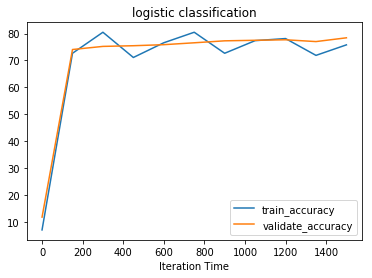

In [40]:
result_lc = run_training(3001,graph_lc,lr = 0.5)
plot_accuracy_history(result_lc,title = 'logistic classification')

### Logistic Classification with L2 Regularization

Initialized
Minibatch loss at step 0: 22.162886
Minibatch loss at step 300: 4.503520
Minibatch loss at step 600: 3.009377
Minibatch loss at step 900: 2.509858
Minibatch loss at step 1200: 1.559438
Minibatch loss at step 1500: 1.039076
Minibatch loss at step 1800: 1.293847
Minibatch loss at step 2100: 0.923833
Minibatch loss at step 2400: 0.845308
Minibatch loss at step 2700: 0.797584
Minibatch loss at step 3000: 0.837221
Test accuracy: 88.9%


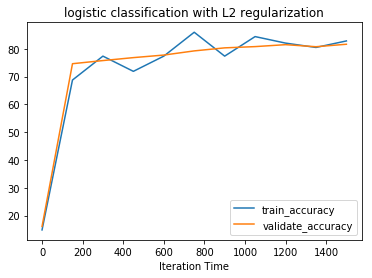

In [43]:
result_lc_L2 = run_training(3001,graph_lc,lr = 0.5,beta=1e-3)
plot_accuracy_history(result_lc_L2,title = 'logistic classification with L2 regularization')

In [20]:
def model(X):
    # five layers and their number of neurons (tha last layer has 10 softmax neurons)
    L = 200
    M = 100
    N = 60
    O = 30
    # Weights initialised with small random values between -0.2 and +0.2
    # When using RELUs, make sure biases are initialised with small *positive* values for example 0.1 = tf.ones([K])/10
    W1 = tf.Variable(tf.truncated_normal([784, L], stddev=0.1))  # 784 = 28 * 28
    B1 = tf.Variable(tf.ones([L])/10)
    W2 = tf.Variable(tf.truncated_normal([L, M], stddev=0.1))
    B2 = tf.Variable(tf.ones([M])/10)
    W3 = tf.Variable(tf.truncated_normal([M, N], stddev=0.1))
    B3 = tf.Variable(tf.ones([N])/10)
    W4 = tf.Variable(tf.truncated_normal([N, O], stddev=0.1))
    B4 = tf.Variable(tf.ones([O])/10)
    W5 = tf.Variable(tf.truncated_normal([O, 10], stddev=0.1))
    B5 = tf.Variable(tf.zeros([10]))

    # The model, with dropout at each layer
    XX = tf.reshape(X, [-1, 28*28])

    Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
    Y1d = tf.nn.dropout(Y1, pkeep)

    Y2 = tf.nn.relu(tf.matmul(Y1d, W2) + B2)
    Y2d = tf.nn.dropout(Y2, pkeep)

    Y3 = tf.nn.relu(tf.matmul(Y2d, W3) + B3)
    Y3d = tf.nn.dropout(Y3, pkeep)

    Y4 = tf.nn.relu(tf.matmul(Y3d, W4) + B4)
    Y4d = tf.nn.dropout(Y4, pkeep)

    Ylogits = tf.matmul(Y4d, W5) + B5
    Y = tf.nn.softmax(Ylogits)
    return Ylogits

# Fully Connected Neural Network

## 1-hidden layer Neural Network

In [44]:
def nn_1h(x, weights, biases,relu = 1):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    if (relu == 1):
        layer_1 = tf.nn.relu(layer_1)
    else:
        layer_1 = tf.nn.sigmoid(layer_1)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    return out_layer

graph_nn_1h = tf.Graph()
with graph_nn_1h.as_default():  
  batch_size = 128
  n_hidden_1 = 1024 # 1st layer number of features
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)
  relu_flag = tf.placeholder(tf.int8)
  
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'out': tf.Variable(tf.random_normal([n_hidden_1, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }
  logits = nn_1h(tf_train_dataset, weights, biases,relu_flag)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
      regu_beta * tf.nn.l2_loss(weights['out']) +
      regu_beta * tf.nn.l2_loss(weights['h1'])
  )
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(nn_1h(tf_valid_dataset, weights, biases,relu_flag))
  test_prediction = tf.nn.softmax(nn_1h(tf_test_dataset, weights, biases,relu_flag))

### ReLu vs. Sigmoid

Initialized
Minibatch loss at step 0: 33.065933
Minibatch loss at step 300: 4.565727
Minibatch loss at step 600: 3.693823
Minibatch loss at step 900: 3.023897
Minibatch loss at step 1200: 1.645992
Minibatch loss at step 1500: 0.990770
Minibatch loss at step 1800: 2.444775
Minibatch loss at step 2100: 1.076867
Minibatch loss at step 2400: 1.378235
Minibatch loss at step 2700: 1.253860
Minibatch loss at step 3000: 1.290223
Test accuracy: 88.7%
CPU times: user 3min 30s, sys: 8.11 s, total: 3min 38s
Wall time: 1min 7s


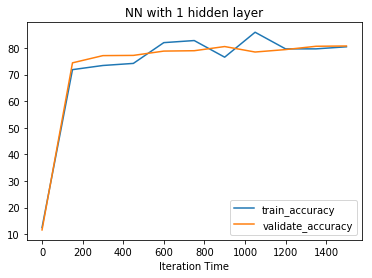

In [47]:
%time result_nn_1h = run_training(3001,graph_nn_1h,lr = 0.5)
plot_accuracy_history(result_nn_1h,title = 'NN with 1 hidden layer')

Initialized
Minibatch loss at step 0: 30.393391
Minibatch loss at step 300: 3.524937
Minibatch loss at step 600: 3.252167
Minibatch loss at step 900: 2.377924
Minibatch loss at step 1200: 1.656587
Minibatch loss at step 1500: 1.245952
Minibatch loss at step 1800: 1.747317
Minibatch loss at step 2100: 1.449013
Minibatch loss at step 2400: 1.330536
Minibatch loss at step 2700: 1.115315
Minibatch loss at step 3000: 1.218311
Test accuracy: 87.6%
CPU times: user 3min 26s, sys: 9.9 s, total: 3min 36s
Wall time: 1min 7s


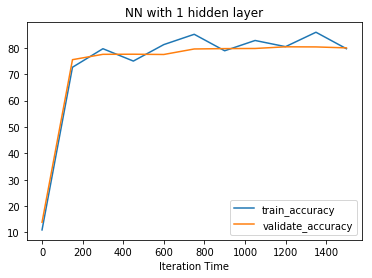

In [48]:
%time result_nn_1h_sigmoid = run_training(3001,graph_nn_1h,lr = 0.5,relu = 0)
plot_accuracy_history(result_nn_1h_sigmoid,title = 'NN with 1 hidden layer')

Initialized
Minibatch loss at step 0: 436.453064
Minibatch loss at step 300: 303.550293
Minibatch loss at step 600: 225.078674
Minibatch loss at step 900: 166.934235
Minibatch loss at step 1200: 123.082016
Minibatch loss at step 1500: 91.569809
Minibatch loss at step 1800: 68.465240
Minibatch loss at step 2100: 50.813324
Minibatch loss at step 2400: 37.699894
Minibatch loss at step 2700: 29.145447
Minibatch loss at step 3000: 20.878002
Test accuracy: 89.5%


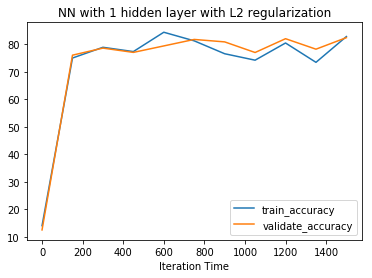

In [52]:
result_nn_1h_L2 = run_training(3001,graph_nn_1h,lr = 0.5,beta = 1e-3)
plot_accuracy_history(result_nn_1h_L2,title = 'NN with 1 hidden layer with L2 regularization')

## 2-hidden layer Neural Network

In [65]:
def nn_2h(x, weights, biases,relu = 1):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    if (relu == 1):
        layer_1 = tf.nn.relu(layer_1)
    else:
        layer_1 = tf.nn.sigmoid(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    if (relu == 1):
        layer_2 = tf.nn.relu(layer_2)
    else:
        layer_2 = tf.nn.sigmoid(layer_2)
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

graph_nn_2h = tf.Graph()
with graph_nn_2h.as_default():  
  batch_size = 128
  n_hidden_1 = 1024 # 1st layer number of features
  n_hidden_2 = 256 # 1st layer number of features
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)
  relu_flag = tf.placeholder(tf.int8)
  
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
     'out': tf.Variable(tf.random_normal([n_hidden_2, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }
  logits = nn_2h(tf_train_dataset, weights, biases,relu_flag)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
      regu_beta * tf.nn.l2_loss(weights['out']) +
      regu_beta * tf.nn.l2_loss(weights['h1']) +
      regu_beta * tf.nn.l2_loss(weights['h2'])
  )
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(nn_2h(tf_valid_dataset, weights, biases,relu_flag))
  test_prediction = tf.nn.softmax(nn_2h(tf_test_dataset, weights, biases,relu_flag))

Initialized
Minibatch loss at step 0: 18.396400
Minibatch loss at step 300: 1.316361
Minibatch loss at step 600: 1.337265
Minibatch loss at step 900: 1.167573
Minibatch loss at step 1200: 0.707752
Minibatch loss at step 1500: 0.733797
Minibatch loss at step 1800: 0.857349
Minibatch loss at step 2100: 0.669286
Minibatch loss at step 2400: 0.727261
Minibatch loss at step 2700: 0.666039
Minibatch loss at step 3000: 0.851142
Test accuracy: 86.0%
CPU times: user 4min 29s, sys: 13.4 s, total: 4min 42s
Wall time: 1min 30s


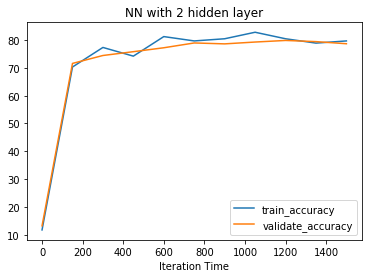

In [58]:
%time result_nn_2h = run_training(3001,graph_nn_2h,lr = 0.5)
plot_accuracy_history(result_nn_2h,title = 'NN with 2 hidden layer')

Initialized
Minibatch loss at step 0: 549.128967
Minibatch loss at step 300: 395.567139
Minibatch loss at step 600: 293.362366
Minibatch loss at step 900: 217.529999
Minibatch loss at step 1200: 160.755280
Minibatch loss at step 1500: 119.159912
Minibatch loss at step 1800: 88.613396
Minibatch loss at step 2100: 65.698502
Minibatch loss at step 2400: 48.852558
Minibatch loss at step 2700: 36.442917
Minibatch loss at step 3000: 27.164310
Test accuracy: 89.2%
CPU times: user 4min 27s, sys: 11.6 s, total: 4min 39s
Wall time: 1min 23s


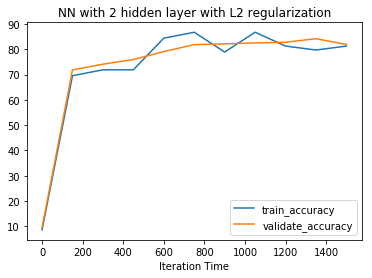

In [59]:
%time result_nn_2h_L2 = run_training(3001,graph_nn_2h,lr = 0.5,beta = 1e-3)
plot_accuracy_history(result_nn_2h_L2,title = 'NN with 2 hidden layer with L2 regularization')

Initialized
Minibatch loss at step 0: 21.221512
Minibatch loss at step 900: 0.929538
Minibatch loss at step 1800: 0.829372
Minibatch loss at step 2700: 0.615279
Minibatch loss at step 3600: 0.839060
Minibatch loss at step 4500: 0.540540
Minibatch loss at step 5400: 0.501989
Minibatch loss at step 6300: 0.617895
Minibatch loss at step 7200: 0.619866
Minibatch loss at step 8100: 0.449775
Minibatch loss at step 9000: 0.902547
Test accuracy: 87.8%
CPU times: user 12min 39s, sys: 35.4 s, total: 13min 15s
Wall time: 4min 16s


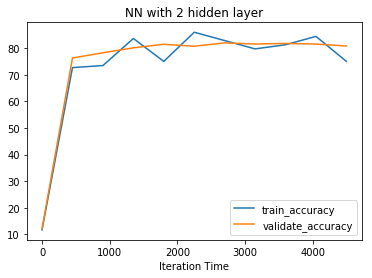

In [60]:
%time result_nn_2h = run_training(9001,graph_nn_2h,lr = 0.5)
plot_accuracy_history(result_nn_2h,title = 'NN with 2 hidden layer')

Initialized
Minibatch loss at step 0: 560.451965
Minibatch loss at step 900: 217.818207
Minibatch loss at step 1800: 88.773071
Minibatch loss at step 2700: 36.478260
Minibatch loss at step 3600: 15.338892
Minibatch loss at step 4500: 6.556841
Minibatch loss at step 5400: 3.142102
Minibatch loss at step 6300: 1.755393
Minibatch loss at step 7200: 1.276191
Minibatch loss at step 8100: 0.795874
Minibatch loss at step 9000: 1.076841
Test accuracy: 88.8%
CPU times: user 12min 36s, sys: 32 s, total: 13min 8s
Wall time: 3min 56s


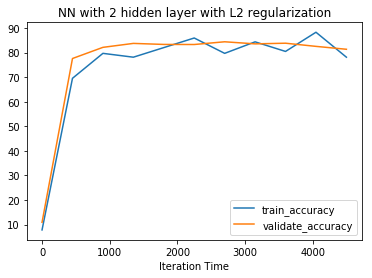

In [66]:
%time result_nn_2h_L2 = run_training(9001,graph_nn_2h,lr = 0.5,beta = 1e-3)
plot_accuracy_history(result_nn_2h_L2,title = 'NN with 2 hidden layer with L2 regularization')

### Learning Rate Decay

In [ ]:
# Clean noisy

In [61]:
graph_nn_2h_decay_lr = tf.Graph()
with graph_nn_2h_decay_lr.as_default():  
  batch_size = 128
  n_hidden_1 = 1024 # 1st layer number of features
  n_hidden_2 = 256 # 1st layer number of features
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)
  relu_flag = tf.placeholder(tf.int8)
  global_step = tf.Variable(0)
  
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
     'out': tf.Variable(tf.random_normal([n_hidden_2, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }
  logits = nn_2h(tf_train_dataset, weights, biases,relu_flag)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
      regu_beta * tf.nn.l2_loss(weights['out']) +
      regu_beta * tf.nn.l2_loss(weights['h1']) +
      regu_beta * tf.nn.l2_loss(weights['h2'])
  )
  
  learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate_decay).minimize(loss,global_step=global_step)
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(nn_2h(tf_valid_dataset, weights, biases,relu_flag))
  test_prediction = tf.nn.softmax(nn_2h(tf_test_dataset, weights, biases,relu_flag))

Initialized
Minibatch loss at step 0: 560.747803
Minibatch loss at step 900: 217.767303
Minibatch loss at step 1800: 117.136543
Minibatch loss at step 2700: 76.667686
Minibatch loss at step 3600: 57.582455
Minibatch loss at step 4500: 47.086128
Minibatch loss at step 5400: 41.205276
Minibatch loss at step 6300: 37.674728
Minibatch loss at step 7200: 35.494179
Minibatch loss at step 8100: 33.802101
Minibatch loss at step 9000: 33.042324
Test accuracy: 91.7%
CPU times: user 12min 33s, sys: 32.8 s, total: 13min 6s
Wall time: 3min 54s


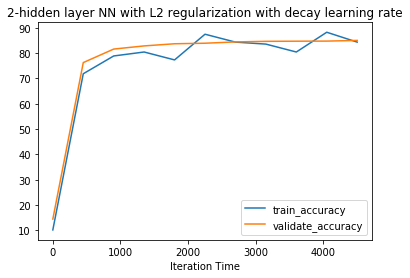

In [63]:
%time result_nn_2h_decay_lr = run_training(9001,graph_nn_2h_decay_lr,lr = 0.5,beta = 1e-3)
plot_accuracy_history(result_nn_2h_decay_lr,title = '2-hidden layer NN with L2 regularization with decay learning rate')

### Dropout

In [1]:
# reduce overfitting

In [67]:
def nn_2h_dropout(x, weights, biases,relu = 1,drop_out = 1.0):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    if (relu == 1):
        layer_1 = tf.nn.relu(layer_1)
    else:
        layer_1 = tf.nn.sigmoid(layer_1)
    
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    if (relu == 1):
        layer_2 = tf.nn.relu(layer_2)
    else:
        layer_2 = tf.nn.sigmoid(layer_2)
    layer_2 = tf.nn.dropout(layer_2,drop_out)
    
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer


graph = tf.Graph()
with graph.as_default():  
  batch_size = 128
  n_hidden_1 = 1024 # 1st layer number of features
  n_hidden_2 = 256 # 1st layer number of features
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)
  relu_flag = tf.placeholder(tf.int8)
  global_step = tf.Variable(0)
  
  weights = {
     'h1': tf.Variable(tf.random_normal([image_size * image_size, n_hidden_1])),
     'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
     'out': tf.Variable(tf.random_normal([n_hidden_2, num_labels]))
  }
  biases = {
     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
     'out': tf.Variable(tf.random_normal([num_labels]))
  }
  logits = nn_2h_dropout(tf_train_dataset, weights, biases,relu_flag,drop_out = pkeep)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)+
      regu_beta * tf.nn.l2_loss(weights['out']) +
      regu_beta * tf.nn.l2_loss(weights['h1']) +
      regu_beta * tf.nn.l2_loss(weights['h2'])
  )
  
  learning_rate_decay = tf.train.exponential_decay(learning_rate, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate_decay).minimize(loss,global_step=global_step)
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(nn_2h(tf_valid_dataset, weights, biases,relu_flag))
  test_prediction = tf.nn.softmax(nn_2h(tf_test_dataset, weights, biases,relu_flag))

Initialized
Minibatch loss at step 0: 557.361450
Minibatch loss at step 900: 217.645905
Minibatch loss at step 1800: 117.371567
Minibatch loss at step 2700: 76.826920
Minibatch loss at step 3600: 57.631477
Minibatch loss at step 4500: 47.195255
Minibatch loss at step 5400: 41.286560
Minibatch loss at step 6300: 37.753998
Minibatch loss at step 7200: 35.607227
Minibatch loss at step 8100: 33.920155
Minibatch loss at step 9000: 33.112030
Test accuracy: 91.3%
CPU times: user 12min 52s, sys: 36.7 s, total: 13min 29s
Wall time: 4min 16s


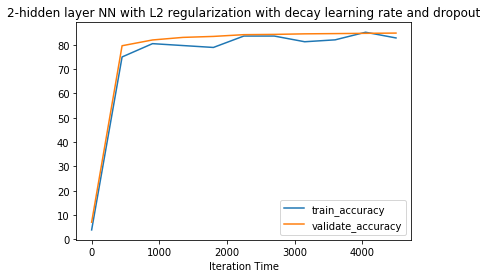

In [68]:
%time result_nn_2h_decay_lr_dropout = run_training(9001,graph,lr = 0.5,beta = 1e-3,dropout = 0.75)
plot_accuracy_history(result_nn_2h_decay_lr_dropout,title = '2-hidden layer NN with L2 regularization with decay learning rate and dropout')

# Convolution Neural Network

In [75]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [76]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


Convonlution Neural Networks(COVNETS) are Neural Networks that share their parameters across space. CNN is ideal for image recognitions.

## Stride VS. Pooling

In [77]:
graph = tf.Graph()
with graph.as_default():
  batch_size = 16
  patch_size = 5
  depth = 16
  num_hidden = 64
  num_channels = 1
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)
  relu_flag = tf.placeholder(tf.int8)
  global_step = tf.Variable(0)
  
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

Initialized
Minibatch loss at step 0: 2.946635
Minibatch loss at step 100: 1.062271
Minibatch loss at step 200: 1.125587
Minibatch loss at step 300: 0.341779
Minibatch loss at step 400: 0.376066
Minibatch loss at step 500: 0.738973
Minibatch loss at step 600: 0.343867
Minibatch loss at step 700: 0.933351
Minibatch loss at step 800: 0.530879
Minibatch loss at step 900: 0.657999
Minibatch loss at step 1000: 0.284990
Test accuracy: 89.3%
CPU times: user 36.6 s, sys: 24.8 s, total: 1min 1s
Wall time: 24.6 s


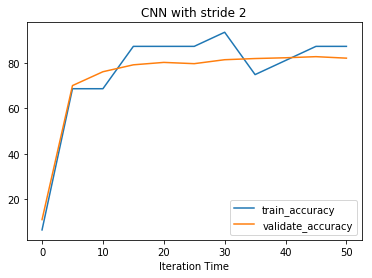

In [78]:
%time result_cnn_stride = run_training(1001,graph,lr = 0.05)
plot_accuracy_history(result_cnn_stride,title = 'CNN with stride 2')

In [79]:
graph = tf.Graph()
with graph.as_default():
  batch_size = 16
  patch_size = 5
  depth = 16
  num_hidden = 64
  num_channels = 1
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)
  relu_flag = tf.placeholder(tf.int8)
  global_step = tf.Variable(0)
  
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

  def model(data):
    k =2
    stride = 2
    conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, k, k, 1], strides=[1, stride, stride, 1],
                          padding='SAME')
    conv = tf.nn.conv2d(pool, layer2_weights, [1, 1, 1, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    pool = tf.nn.max_pool(hidden, ksize=[1, k, k, 1], strides=[1, stride, stride, 1],
                          padding='SAME')
      
    shape = pool.get_shape().as_list()
    reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))


Initialized
Minibatch loss at step 0: 2.742388
Minibatch loss at step 100: 1.233572
Minibatch loss at step 200: 0.920397
Minibatch loss at step 300: 0.470889
Minibatch loss at step 400: 0.278884
Minibatch loss at step 500: 0.617461
Minibatch loss at step 600: 0.395510
Minibatch loss at step 700: 0.918802
Minibatch loss at step 800: 0.568405
Minibatch loss at step 900: 0.572536
Minibatch loss at step 1000: 0.274879
Test accuracy: 90.8%
CPU times: user 2min 27s, sys: 55.8 s, total: 3min 22s
Wall time: 1min 25s


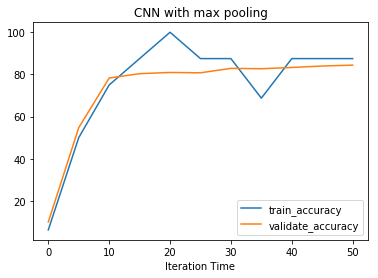

In [80]:
%time result_cnn_pooling= run_training(1001,graph,lr = 0.05)
plot_accuracy_history(result_cnn_pooling,title = 'CNN with max pooling')

## LeNet

In [83]:
from IPython.display import display, Image
lenet5 = Image(url = 'http://eblearn.sourceforge.net/lib/exe/lenet5.png')
display(lenet5)

Architecture

Layer 1: Convolutional. The output shape is 28x28x6.

Activation. Let's use ReLu activation function.

Pooling. The output shape is 14x14x6.

Layer 2: Convolutional. The output shape is 10x10x16.

Activation. Let's use ReLu activation function.

Pooling. The output shape is 5x5x16.

Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

Layer 3: Fully Connected. This one have 120 outputs.

Activation. Let's use ReLu activation function.

Layer 4: Fully Connected. This one have 84 outputs.

Activation. Let's use ReLu activation function.

Layer 5: Fully Connected (Logits). This one have 10 outputs.



[LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)

In [81]:
graph = tf.Graph()
with graph.as_default():
  batch_size = 16
  patch_size = 5
  depth1 = 6
  depth2 = 16
  num_hidden_1 = 120
  num_hidden_2 = 84

  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  learning_rate = tf.placeholder(tf.float32)
  pkeep = tf.placeholder(tf.float32)
  regu_beta = tf.placeholder(tf.float32)
  relu_flag = tf.placeholder(tf.int8)
  global_step = tf.Variable(0)
  
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth1], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth1]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth1, depth2], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth2]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [5*5*depth2, num_hidden_1], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_1]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_1, num_hidden_2], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden_2]))
  layer5_weights = tf.Variable(tf.truncated_normal(
      [num_hidden_2, num_labels], stddev=0.1))
  layer5_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # Layer 1: Convolutional. Input = 32x32x1(paper) 28x28x1(here). Output = 28x28x6.
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
    conv1 = tf.nn.relu(conv1 + layer1_biases)
    pool1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    # Layer 2: Convolutional. Output = 10x10x16.    
    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='VALID')
    conv2 = tf.nn.relu(conv2 + layer2_biases)
    pool2 = tf.nn.max_pool(conv2, [1, 2, 2, 1], [1, 2, 2, 1],padding='VALID')
    
    # Flatten. Input = 5x5x16. Output = 400.
    shape = pool2.get_shape().as_list()
    reshape = tf.reshape(pool2, [shape[0], shape[1] * shape[2] * shape[3]])
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.    
    # Activation.
    fc1 = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

    # Layer 4: Fully Connected. Input = 120. Output = 84.    
    # Activation.
    fc2 = tf.nn.relu(tf.matmul(fc1, layer4_weights) + layer4_biases)

    # Layer 5: Fully Connected. Input = 84. Output = 10.
    return tf.matmul(fc2, layer5_weights) + layer5_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
#   optimizer =  tf.train.AdamOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))



Initialized
Minibatch loss at step 0: 3.287983
Minibatch loss at step 5000: 1.216957
Minibatch loss at step 10000: 0.258969
Minibatch loss at step 15000: 0.687078
Minibatch loss at step 20000: 0.436444
Minibatch loss at step 25000: 0.868046
Minibatch loss at step 30000: 0.810472
Minibatch loss at step 35000: 0.660300
Minibatch loss at step 40000: 0.703985
Minibatch loss at step 45000: 0.425046
Minibatch loss at step 50000: 0.222826
Test accuracy: 93.0%
CPU times: user 20min 20s, sys: 13min 59s, total: 34min 20s
Wall time: 14min 19s


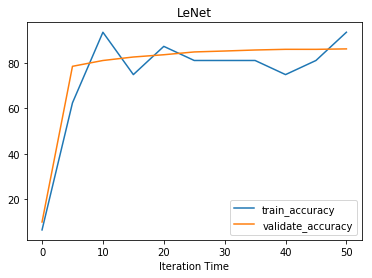

In [82]:
%time result_cnn_lenet= run_training(50001,graph,lr = 1e-3)
plot_accuracy_history(result_cnn_lenet,title = 'LeNet')